In [1]:
import os
import random
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io
from shapely.geometry import Polygon

import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO

from dataset_preparing import get_coords_from_densifing_points, generate_heatmap
from dataloader_cocostyle import CrowdAI, image_graph_collate_road_network_coco, min_max_normalize

from models.backbone_R2U_Net import build_backbone
from models.TopDiG import build_TopDiG

from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import yaml
import json

class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
        
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

### Inria cocostyle GT 예시

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Built Dataset Options:
--Num.of images: 1355
--Gap Distance: 10 --Sigma: 1.0 --nms: False
torch.Size([6, 3, 320, 320])


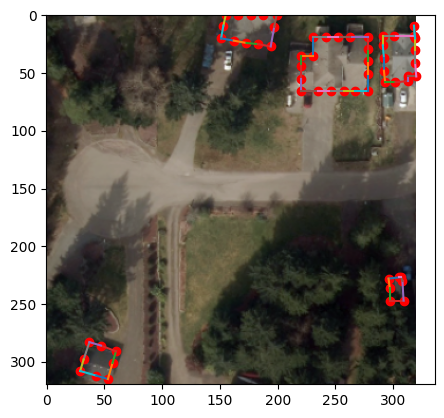

In [2]:
dataset = CrowdAI(images_directory='/nas/tsgil/dataset/Inria_building/cocostyle_inria_test/images',
                    annotations_path='/nas/tsgil/dataset/Inria_building/cocostyle_inria_test/annotation.json')
sampler = torch.utils.data.SequentialSampler(dataset)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, sampler=sampler, collate_fn=image_graph_collate_road_network_coco)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

# 6개의 이미지 중 i번째 GT
idx_of_batch = 5

image = data[0][idx_of_batch].detach().cpu().numpy().transpose(1,2,0)
heatmap =  data[1][idx_of_batch].detach().cpu().numpy()
nodes = data[2][idx_of_batch].detach().cpu().numpy() * image.shape[0]
edges = data[3][idx_of_batch].detach().cpu().numpy()

nodes = nodes.astype('int64')

# Visualize
plt.imshow(min_max_normalize(image, 0))
plt.scatter(nodes[:,1], nodes[:,0], color='r')

for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    plt.plot(connect[:,1], connect[:,0])
plt.show()

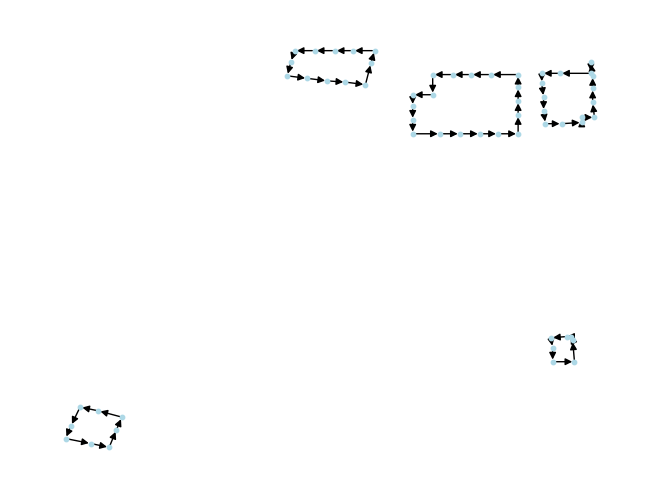

In [3]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

GT = nx.DiGraph()
np.min(edges)
for i in range(len(nodes)):
    GT.add_node(i)
GT.add_edges_from(edges)
pos_GT = {i: (node[1], 320-node[0]) for i, node in enumerate(nodes)}
for node, position in pos_GT.items():
    GT.nodes[node]['pos'] = position
nx.draw(GT, pos_GT, with_labels=False, node_color='lightblue', node_size=10)
plt.show()

In [4]:
import geopandas as gpd
from shapely.geometry import Polygon

def cycles_to_geodf(G, cycles):
    polygons = []
    for cycle in cycles:
        if len(cycle) > 2:  # Polygon needs at least 3 points
            points = [G.nodes[node]['pos'] for node in cycle]  # Assuming 'pos' contains coordinates
            polygons.append(Polygon(points))
    
    return gpd.GeoDataFrame(geometry=polygons)

# Convert cycles to a GeoDataFrame
cycles_GT = list(nx.simple_cycles(GT))
print(len(cycles_GT))
geo_df_GT = cycles_to_geodf(GT, cycles_GT)

5


<Axes: >

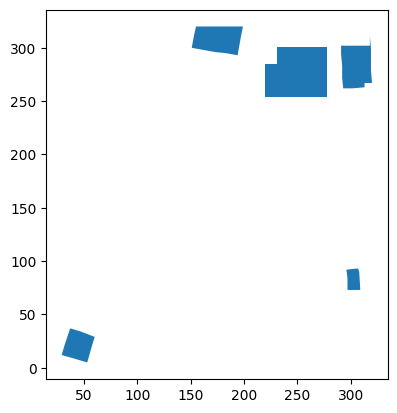

In [5]:
geo_df_GT.plot()

TopDiG, 백본 ckpt 불러오기

In [6]:
# config_file = "/nas/tsgil/TopDiG_train/runs/baseline_TopDiG_train_epoch20_sinkhorn_K-N_10/config.yaml"
config_file = "/nas/tsgil/relationformer/work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_diag_weight_10/config.yaml"
# config_file = "/nas/tsgil/relationformer/work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_diag_weight_10/config.yaml"
# config_file = "/nas/tsgil/relationformer/configs/TopDiG_train.yaml"
config_file2 = "configs/inria_pretrain.yaml"
ckpt_backbone_path = "/nas/tsgil/gil/picked_backbone/epochs_130_5e-6.pth"
# ckpt_path = "/nas/tsgil/relationformer/work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_weighted_ce_10/models/epochs_20.pth"
# ckpt_path = "/nas/tsgil/TopDiG_train/runs/baseline_TopDiG_train_epoch20_sinkhorn_K-N_10/models/epochs_20.pth"
ckpt_path = "/nas/tsgil/relationformer/work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_diag_weight_10/models/epochs_20.pth"
# ckpt_path = "/nas/tsgil/relationformer/work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_diag_weight_10/models/epochs_20.pth"

with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2obj(config)

with open(config_file2) as f:
    config2 = yaml.load(f, Loader=yaml.FullLoader)
config2 = dict2obj(config2)

model = build_TopDiG(config) # 빌드 함수 내부에서 ckpt 파일 로드함

checkpoint = torch.load(ckpt_backbone_path, map_location='cpu')
print(checkpoint['model_state_dict'].keys())
print(model.state_dict().keys())

checkpoint2 = torch.load(ckpt_path, map_location='cpu')
missing_keys, unexpected_keys = model.load_state_dict(checkpoint2['model_state_dict'], strict=False) # 여기서 TopDiG 학습한 체크포인트 로드
unexpected_keys = [k for k in unexpected_keys if not (k.endswith('total_params') or k.endswith('total_ops'))]
if len(missing_keys) > 0:
    print('Missing Keys: {}'.format(missing_keys))
if len(unexpected_keys) > 0:
    print('Unexpected Keys: {}'.format(unexpected_keys))
# model.eval()
device = torch.device("cuda")
# device = torch.device("cpu")
model = model.to(device)

odict_keys(['encoder.RRCNN1.RCNN.0.conv.0.weight', 'encoder.RRCNN1.RCNN.0.conv.0.bias', 'encoder.RRCNN1.RCNN.0.conv.1.weight', 'encoder.RRCNN1.RCNN.0.conv.1.bias', 'encoder.RRCNN1.RCNN.0.conv.1.running_mean', 'encoder.RRCNN1.RCNN.0.conv.1.running_var', 'encoder.RRCNN1.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN1.RCNN.1.conv.0.weight', 'encoder.RRCNN1.RCNN.1.conv.0.bias', 'encoder.RRCNN1.RCNN.1.conv.1.weight', 'encoder.RRCNN1.RCNN.1.conv.1.bias', 'encoder.RRCNN1.RCNN.1.conv.1.running_mean', 'encoder.RRCNN1.RCNN.1.conv.1.running_var', 'encoder.RRCNN1.RCNN.1.conv.1.num_batches_tracked', 'encoder.RRCNN1.Conv_1x1.weight', 'encoder.RRCNN1.Conv_1x1.bias', 'encoder.RRCNN2.RCNN.0.conv.0.weight', 'encoder.RRCNN2.RCNN.0.conv.0.bias', 'encoder.RRCNN2.RCNN.0.conv.1.weight', 'encoder.RRCNN2.RCNN.0.conv.1.bias', 'encoder.RRCNN2.RCNN.0.conv.1.running_mean', 'encoder.RRCNN2.RCNN.0.conv.1.running_var', 'encoder.RRCNN2.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN2.RCNN.1.conv.0.weight', 'enc

In [7]:
images = torch.zeros((6,3,320,320)).to(device)
for i, image in enumerate(data[0]):
    image = resize(image, (3, 320, 320), anti_aliasing=True, preserve_range=True)
    images[i] = torch.tensor(image).to(device)
with torch.no_grad():
    out = model(images)
scores1, scores2 = out['scores1'], out['scores2']
htm_TopDiG, nms_TopDiG = out['pred_heatmaps'], (out['pred_nodes']*320)
nms_TopDiG = nms_TopDiG.type(torch.int)
print(htm_TopDiG[1].unique())
print(nms_TopDiG[1][:10])

tensor([-35.2117, -35.1172, -35.0238,  ...,   5.2839,   5.3035,   5.3937],
       device='cuda:0')
tensor([[ 81,   0],
        [ 18,   0],
        [ 63, 296],
        [ 39,   0],
        [146,  29],
        [ 85, 245],
        [ 90, 159],
        [ 59,   0],
        [ 74, 272],
        [ 95, 189]], device='cuda:0', dtype=torch.int32)


matcher로 256개의 노드에 대한 엣지 뽑기 테스트

In [8]:
from scipy.optimize import linear_sum_assignment # Scipy에 구현된 헝가리안 알고리즘 사용

def scores_to_permutations(scores): # 인퍼런스용 함수
    """
    Input a batched array of scores and returns the hungarian optimized 
    permutation matrices.
    """
    B, N, N = scores.shape

    scores = scores.detach().cpu().numpy()
    perm = np.zeros_like(scores)
    for b in range(B):
        # sinkhorn 알고리즘은 비공개된 트레인 파일에 있을 듯
        # 반복적인 노멀라이제이션(100번)을 위해 싱크홀 알고리즘 사용
        # 인퍼런스시에 헝가리안 알고리즘으로 linear sum assignment result 뽑는다
        r, c = linear_sum_assignment(-scores[b]) # 점수가 높을 수록 페어일 확률이 높으므로 -를 붙여서 최소 찾는 문제로 바꾼다.
        perm[b,r,c] = 1 # 헝가리안 알고리즘이 찾은 칸은 1로 아니면 0인 permutation matrix (B N N) 만든다
    return torch.tensor(perm) # 텐서로 바꿔주기

In [9]:
scores1[1].unique()


tensor([-24.5026, -24.4498, -24.0539,  ...,   2.5962,   2.6787,   3.2252],
       device='cuda:0')

torch.Size([6, 256, 256])


[[ 61 319]
 [ 17 319]
 [  0 197]
 [  0 158]
 [ 62 299]
 [ 10 258]
 [ 39 319]
 [294  62]
 [319  51]
 [  0 177]]
[(0, 6), (1, 28), (2, 9), (3, 44), (4, 0), (5, 26), (6, 1), (7, 27), (8, 72), (9, 3), (10, 19), (11, 22), (12, 8), (13, 20), (14, 37), (15, 35), (17, 4), (18, 82), (19, 21), (20, 38), (21, 42), (22, 24), (23, 39), (24, 18), (26, 40), (27, 13), (28, 56), (29, 31), (30, 17), (31, 10), (33, 23), (34, 14), (35, 36), (36, 41), (37, 46), (38, 12), (39, 34), (40, 15), (41, 11), (42, 2), (44, 29), (45, 52), (46, 5), (47, 87), (48, 59), (49, 30), (50, 33), (52, 53), (53, 45), (54, 58), (56, 57), (57, 47), (58, 61), (59, 49), (60, 54), (61, 60), (65, 48), (66, 70), (70, 246), (71, 89), (72, 7), (73, 86), (74, 75), (75, 80), (78, 84), (80, 74), (81, 88), (82, 109), (84, 85), (85, 135), (86, 73), (87, 101), (88, 81), (89, 71), (90, 162), (91, 96), (93, 91), (94, 98), (95, 171), (96, 93), (98, 94), (101, 177), (102, 118), (104, 178), (105, 231), (106, 129), (107, 122), (109, 50), (110, 210

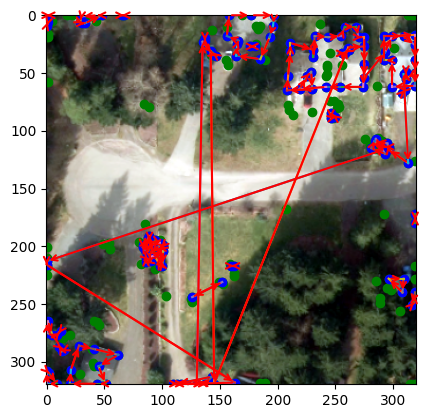

In [10]:
# idx_of_batch = 4

scores = scores1.sigmoid() + scores2.transpose(1,2).sigmoid()

permu = scores_to_permutations(scores)
print(permu.shape)
mat = permu[idx_of_batch].numpy()
edges = []
for i in range(len(mat)):
    for j in range(len(mat)):
        if mat[i][j] == 1:
            if i != j:
                # print(i, j)
                edges.append((i,j))
nodes = nms_TopDiG.detach().cpu().numpy()
image = images[idx_of_batch].detach().cpu().numpy().transpose(1,2,0)
nodes = nodes[idx_of_batch]
print(nodes[:10])
print(edges)

print("예측 노드 수:", len(nodes))
print("선택된 예측 노드 수:", len(edges))
print("정답 노드 수:", len(data[2][1].detach().cpu().numpy()))

# Visualize
plt.imshow(min_max_normalize(image, 0.5))
# plt.imshow(htm_TopDiG[idx_of_batch,0].detach().cpu().numpy())
plt.scatter(nodes[:,1], nodes[:,0], color='g')
for x, _ in edges:
    plt.scatter(nodes[x][1], nodes[x][0], color='b')
for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    plt.plot(connect[:,1], connect[:,0])
    plt.annotate("", xy=nodes[e[0]][::-1], xytext=nodes[e[1]][::-1], 
                arrowprops=dict(arrowstyle="->", lw=1.5, color='r'))

plt.show()

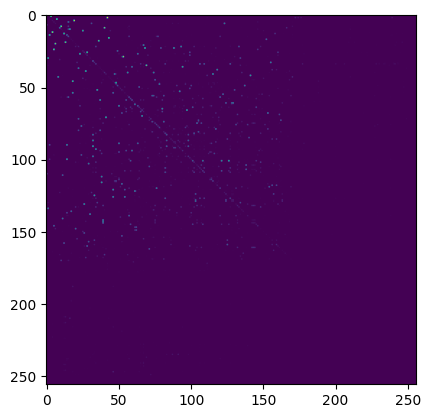

In [11]:
plt.imshow(scores1[1].sigmoid().cpu().numpy())

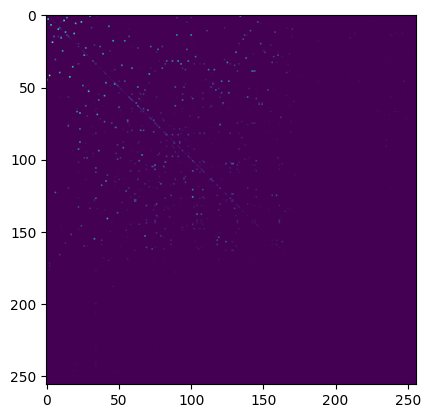

In [12]:
plt.imshow(scores2[1].sigmoid().cpu().numpy())

In [13]:
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for i in range(256):
    G.add_node(i)
G.add_edges_from(edges)
G.number_of_nodes()
G.number_of_edges()

160

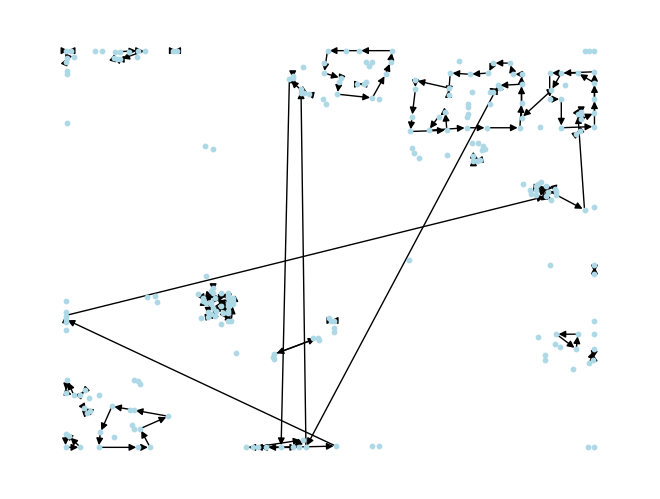

In [14]:
pos = {i: (node[1], 320-node[0]) for i, node in enumerate(nodes)}
for node, position in pos.items():
    G.nodes[node]['pos'] = position
nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=10)
plt.show()

In [15]:
import geopandas as gpd
from shapely.geometry import Polygon

def cycles_to_geodf(G, cycles):
    polygons = []
    for cycle in cycles:
        if len(cycle) > 2:  # Polygon needs at least 3 points
            points = [G.nodes[node]['pos'] for node in cycle]  # Assuming 'pos' contains coordinates
            polygons.append(Polygon(points))
    
    return gpd.GeoDataFrame(geometry=polygons)

# Convert cycles to a GeoDataFrame
cycles = list(nx.simple_cycles(G))
print(len(cycles))
geo_df = cycles_to_geodf(G, cycles)

31


<Axes: >

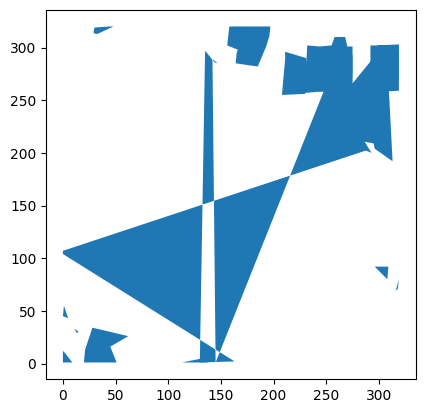

In [16]:
geo_df.plot()

In [17]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.transform import from_origin
# Example GeoDataFrame
gdf = geo_df
gdf_GT = geo_df_GT

pixel_size = 1
x_min, y_min, x_max, y_max = 0, 0, 320, 320
width = int((x_max - x_min) / pixel_size)
height = int((y_max - y_min) / pixel_size)

# Create a transform (assumes north-up and no rotation)
transform = from_origin(x_min, y_max, pixel_size, pixel_size)

# Convert the GeoDataFrame to a raster array
shapes = ((geom, 1) for geom in gdf.geometry)
rasterized = rasterio.features.rasterize(shapes=shapes, out_shape=(height, width), transform=transform)

shapes = ((geom, 1) for geom in gdf_GT.geometry)
rasterized_GT = rasterio.features.rasterize(shapes=shapes, out_shape=(height, width), transform=transform)


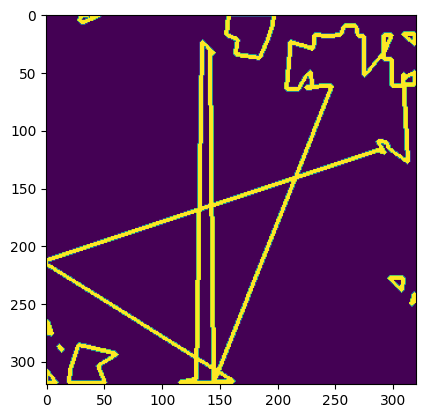

In [18]:
from scipy.ndimage import binary_dilation, binary_erosion

# Dilate the raster
dilated = binary_dilation(rasterized, iterations=2)

# Erode the raster
eroded = binary_erosion(rasterized, iterations=2)
result1 = dilated ^ eroded
plt.imshow(result1)

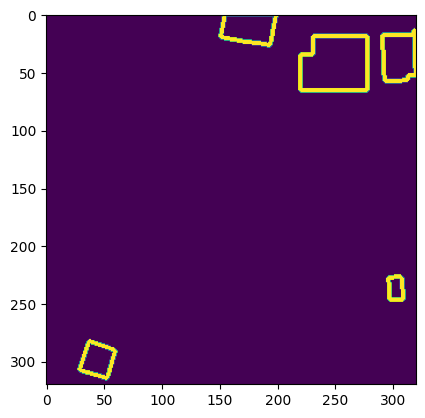

In [19]:
# Dilate the raster
dilated = binary_dilation(rasterized_GT, iterations=2)

# Erode the raster
eroded = binary_erosion(rasterized_GT, iterations=2)
result2 = dilated ^ eroded
plt.imshow(result2)

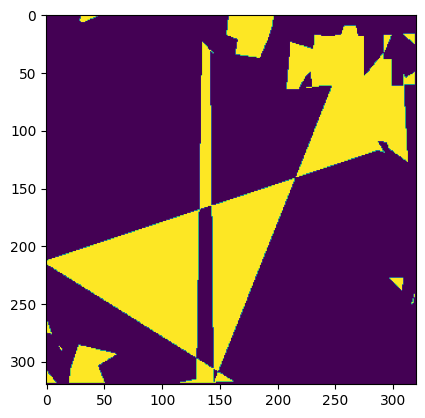

In [20]:
plt.imshow(rasterized)

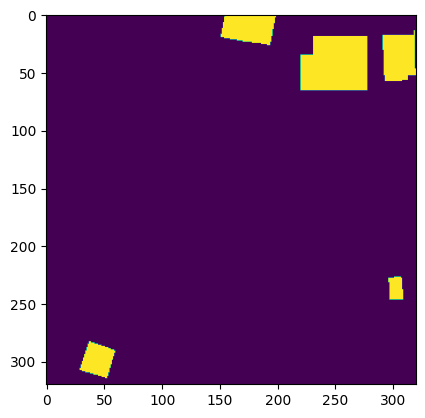

In [21]:
plt.imshow(rasterized_GT)

In [22]:
# Assuming raster1 and raster2 are your two rasters as NumPy arrays
raster1_flat = rasterized.flatten()
raster2_flat = rasterized_GT.flatten()
np.unique(raster1_flat)

array([0, 1], dtype=uint8)

### PIXEL-wise metrics

In [23]:
from sklearn.metrics import f1_score, accuracy_score, jaccard_score

# Accuracy
accuracy = accuracy_score(raster1_flat, raster2_flat)

# F1 Score
f1 = f1_score(raster1_flat, raster2_flat, average='macro')  # 'macro' for unweighted mean across classes

# Mean IoU
miou = jaccard_score(raster1_flat, raster2_flat, average='macro')
# miou = jaccard_score(raster1_flat, raster2_flat)


In [24]:
print(accuracy, f1, miou)

0.7646484375 0.5524262744162726 0.4472230440346832


### TOPO-wise metrics

In [25]:
# Assuming raster1 and raster2 are your two rasters as NumPy arrays
raster1_flat = result1.flatten()
raster2_flat = result2.flatten()
# Accuracy
accuracy = accuracy_score(raster1_flat, raster2_flat)

# F1 Score
f1 = f1_score(raster1_flat, raster2_flat, average='macro')  # 'macro' for unweighted mean across classes

# Mean IoU
miou = jaccard_score(raster1_flat, raster2_flat, average='macro')
# miou = jaccard_score(raster1_flat, raster2_flat)


In [26]:
print(accuracy, f1, miou)

0.91015625 0.5531746320118383 0.49635842101513206
